In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch
# from matplotlib.mlab import rec2csv

import emcee
import corner

import _pickle as cPickle
# from astropy.io import ascii

In [2]:
import matplotlib as mpl
from scipy.stats import gaussian_kde

In [3]:
cat = np.genfromtxt('../forElena16Nov/SAGITTARIUS-II_cat16Nov.dat',names=True)

In [4]:
cat.dtype.names

('x_f606w',
 'y_f606w',
 'magr_f606w',
 'flcMag_f606w',
 'err_f606w',
 'star_f606w',
 'x_f814w',
 'y_f814w',
 'magr_f814w',
 'flcMag_f814w',
 'err_f814w',
 'star_f814w')

In [5]:
x = cat['x_f606w']
y = cat['y_f606w']
m606 = cat['magr_f606w']
dm606 = cat['err_f606w']
m814 = cat['magr_f814w']
dm814 = cat['err_f814w']
flag = cat['star_f814w']

In [6]:
# xgood = x
# ygood = y

In [7]:
xgood = x[(flag==1)&(m606-m814 < 0.25)]
ygood = y[(flag==1)&(m606-m814 < 0.25)]

In [8]:
#BEGIN DEFINITION OF A MASK DESCRIBING THE PORTIONS OF THE IMAGE IN WHICH THERE IS DATA

#IMAGE BOUNDARY
IMAGE = Path([ [0,0],
              [200,4025],
              [4200,4200],
              [4090,150],
              [0,0]])

#ACS CHIP GAP
GAP = Path([ [0, 2025],
             [0, 2090],
             [4200, 2240],
             [4200, 2175],
             [0, 2025]])

IMG_BIT = 0b01
GAP_BIT = 0b10

In [9]:
# x0 = 2386.25
# y0 = 2224.53

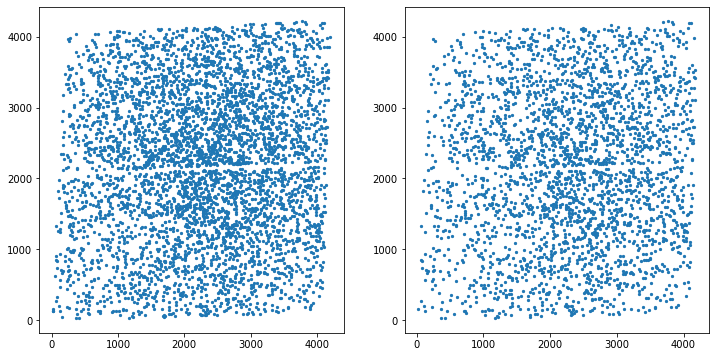

In [10]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))

ax1.scatter(x,y,s=5)
ax2.scatter(xgood,ygood,s=5)
# ax2.plot(x0T,y0T,marker='o',color='red')

plt.show()

In [11]:
# Calculate the point density
xyg = np.vstack([xgood,ygood])
zg = gaussian_kde(xyg)(xyg)

xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

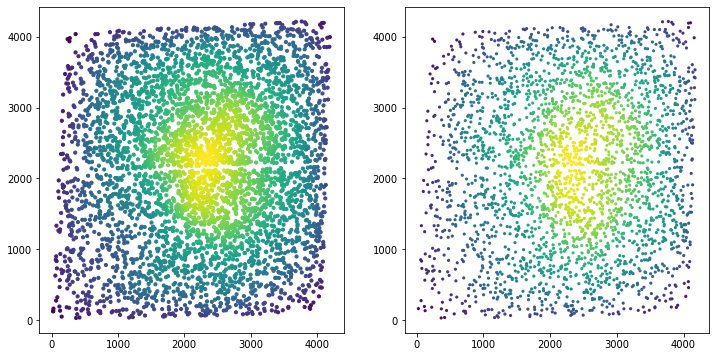

In [12]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))

ax1.scatter(x,y,c=z,s=10)
ax2.scatter(xgood, ygood, c=zg, s=10, edgecolor='')
# ax2.plot(x0T,y0T,marker='o',color='red')

plt.show()

In [13]:
# 19:52:39.91
# -22:53:46.77
# -22:03:54.19

In [14]:
print(max(y))
print(min(y))
print(max(x))
print(min(x))

4215.082095525121
32.27060218618251
4197.571893400599
20.672926914668427


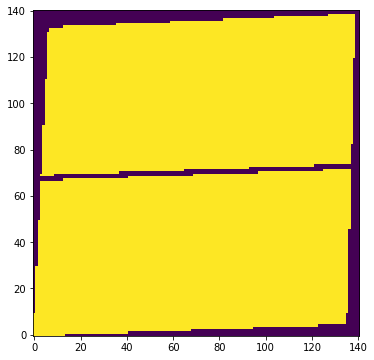

In [15]:
# xmin,xmax = 0,5400
# ymin,ymax = 0,5400

xmin,xmax = 0,4260
ymin,ymax = 0,4260

nbins = 142
xedge = np.linspace(xmin,xmax,nbins)
yedge = np.linspace(ymin,ymax,nbins)

xcent = (xedge[1:] + xedge[:-1])/2
ycent = (yedge[1:] + yedge[:-1])/2

xdel = xedge[1]-xedge[0]
ydel = yedge[1]-yedge[0]

xx,yy = np.meshgrid(xcent,ycent,indexing='ij')

MASK = np.zeros((nbins-1,nbins-1))
image_mask = IMAGE.contains_points(np.vstack([xx.flatten(),yy.flatten()]).T).T.reshape(xx.shape)
gap_mask = GAP.contains_points(np.vstack([xx.flatten(),yy.flatten()]).T).T.reshape(xx.shape)
masked_indices_image = np.where(image_mask==1) # Array indices
masked_indices_gap = np.where(gap_mask==1) # Array indices
MASK[masked_indices_image] = 1
MASK[masked_indices_gap] = 0
IDX = np.where(MASK==1)

#DISPLAY THE MASK TO CHECK THAT IT'S CORRECT
fig,ax = plt.subplots(figsize=(6,6))
# ax.set_xlim(0,160)
# ax.set_ylim(0,160)
plt.imshow(MASK.T,origin='lower')

In [16]:
# sag_x0 = 2386.25
# sag_y0 = 2224.53

# sag_nstar = 1920
# sag_ext = 1.6/60 # degrees
# sag_ext_pix = 2150
# sag_ell = 0.
# sag_pa = 103


sag_x0 = 2500
sag_y0 = 2150

sag_nstar = 4000
sag_ext = 11/60 # degrees
sag_ext_pix = 500
sag_ell = 0.1
sag_pa = 0
# sag_bg = 1

In [17]:
def median_interval(data, alpha=0.32):
    """
    Median including Bayesian credible interval.

    Parameters
    ----------
    data  : posterior samples
    alpha : 1 - confidence interval

    Returns
    -------
    [med,[lo, hi]] : median, lower, and upper percentiles
    
    """
    q = [100*alpha/2., 50, 100*(1-alpha/2.)]
    lo,med,hi = np.percentile(data,q)
    return [med,[lo,hi]]

In [18]:
def data(x,y):
    """ Calculate the binned data counts. This only needs to be done
    once (not at each model evaluation), but this seemed easier to
    understand if it paralleled the model counts calculation.

    Parameters
    ----------
    x : the x coordinate of the data
    y : the y coordinate of the data

    Returns
    -------
    data_counts : the data counts in each bin
    """
    data_counts,_,_ = np.histogram2d(x,y,bins=[xedge,yedge])
    return data_counts

In [19]:
def new_kernel(x,y,lon=sag_x0,lat=sag_y0,ext=sag_ext_pix,ell=sag_ell,pa=sag_pa):
    """ Evaluate the elliptical exponential kernel at coordinates x,y. 
    Normalized to unity over all space...

    Parameters
    ----------
    x: x-coord for evaluating kernel [pix]
    y: y-coord for evaluating kernel [pix]
    lon: x-coord of kernel centroid [pix]
    lat: y-coord of kernel centroid [pix]
    ext: extension [pix]
    ell: ellipticity
    pa:  position angle [deg]

    Returns
    -------
    pdf : probability density (should integrate to unity over all space)
    """

    # Elliptical radius of each x,y coord
    costh = np.cos(np.radians(-pa))
    sinth = np.sin(np.radians(-pa))
    dx = x-lon
    dy = y-lat
    radius = np.sqrt(((dx*costh-dy*sinth)/(1-ell))**2 + (dx*sinth+dy*costh)**2)

    # Exponential radius (re = rh/1.68)
    r_e = ext/1.68 
    #Normalization (integrates to unity over all space) [stars/pix^2)
    norm = 1./(2*np.pi*r_e**2 * (1-ell) )

    # Exponential PDF
    pdf = norm * np.exp(-radius/r_e)

    return pdf

In [20]:
def new_kernel_plummer(x,y,lon=sag_x0,lat=sag_y0,ext=sag_ext_pix,ell=sag_ell,pa=sag_pa):
    """ Evaluate the elliptical Plummer kernel at coordinates x,y. 
    Normalized to unity over all space...

    Parameters
    ----------
    x: x-coord for evaluating kernel [pix]
    y: y-coord for evaluating kernel [pix]
    lon: x-coord of kernel centroid [pix]
    lat: y-coord of kernel centroid [pix]
    ext: extension [pix]
    ell: ellipticity
    pa:  position angle [deg]

    Returns
    -------
    pdf : probability density (should integrate to unity over all space)
    """

    # Elliptical radius of each x,y coord
    costh = np.cos(np.radians(-pa))
    sinth = np.sin(np.radians(-pa))
    dx = x-lon
    dy = y-lat
    radius = np.sqrt(((dx*costh-dy*sinth)/(1-ell))**2 + (dx*sinth+dy*costh)**2)

    #PLUMMER SCALE RADIUS = HALF-LIGHT RADIUS 
    r_e = ext
    #Normalization (integrates to unity over all space?) [stars/pix^2)
    norm = r_e**2/(np.pi*(1-ell))

    # Plummer PDF
    pdf = norm / ((radius**2 + r_e**2)**2)

    return pdf

In [21]:
def model(theta_sag):
    """ Calculate the binned model counts. This extends over the
    entire pixel range, but we will apply the mask later.

    Parameters
    ----------
    theta : the model parameters
    
    Returns
    -------
    model_counts : the model counts in each bin
    """
    #FIT ALL MODEL PARAMETERS
    richness = theta_sag[0]
    kwargs = dict(lon=theta_sag[1],lat=theta_sag[2],ext=theta_sag[3],ell=theta_sag[4],pa=theta_sag[5])
    #THIS CAN BE USED TO HOLD SOME OF THE PARAMETERS FIXED
    # Default values for the other parameters
    #kwargs.update(ext=ERI_EXT_PIX,ell=ERI_ELL)
#     sigma_bg = theta_sag[6]
    #CHANGE KERNEL CALLED HERE TO USE A DIFFERENT FUNCTIONAL FORM FOR THE SURFACE DENSITY OF THE GALAXY
    # The new kernel in pixel coordinates
    pdf = new_kernel_plummer(xx,yy,**kwargs)
#     pdf = new_kernel(xx,yy,**kwargs)

    # Calculate the model predicted counts in each pixel
    pixarea = xdel*ydel
    model_counts = richness * pdf * pixarea  # + sigma_bg
    return model_counts

In [22]:
def lnlike(theta, x, y):
    """ Likelihood function
    Parameters
    ----------
    theta : model parameter array (richness,lon,lat,ext,ell,pa)x2
    x: x-coordinate of data
    y: y-coordinate of data
    
    Returns
    -------
    lnlike: log-likelihood
    """

    #BREAK THETA UP INTO ERI II AND CLUSTER COMPONENTS
    #IF ONLY ONE COMPONENT IS BEING FIT, THEN THESE LINES ARE NOT NEEDED
#     theta_sag = theta[:6]
#     theta_cluster = theta[6:]
    theta_sag = theta
    # Calculate the data counts and model predicted counts in each pixel bin
    data_counts = data(x,y)
    model_counts_sag = model(theta_sag)
#     model_counts_cluster = model_cluster(theta_cluster)
    #TO FIT A SINGLE COMPONENT, USE, E.G., MODEL_COUNTS = MODEL_COUNTS_sag
#     model_counts = model_counts_sag + model_counts_cluster
    model_counts = model_counts_sag 
    
    # Apply the mask to the data and model. This selects only pixels
    # in the image for calculating the likelihood.
#     data_counts_masked = data_counts[IDX]
#     model_counts_masked = model_counts[IDX]

    data_counts_masked = data_counts
    model_counts_masked = model_counts
    
    # Evaluate Equation C2 from Drlica-Wagner et al. 2020 (1912.03302; ignore k! term)
    lnlike = np.sum(-model_counts_masked + data_counts_masked * np.log(model_counts_masked))
    return lnlike

In [23]:
def lnprior(theta):
    """ The log-prior. Add whatever you want here... 
    
    Parameters
    ----------
    theta : model parameters

    Returns
    -------
    lnprior : log-prior
    """
    #PRIORS FOR EACH FITTED PARAMETER

    #TO REMOVE ANY PARAMETER FROM THE FIT, REMOVE IT FROM THE LINE BELOW AND ELIMINATE THE CONSTRAINT FOR IT
#     rich1,lon1,lat1,ext1,ell1,pa1,rich2,lon2,lat2,ext2,ell2,pa2 = theta[0],theta[1],theta[2],theta[3],theta[4],theta[5],theta[6],theta[7],theta[8],theta[9],theta[10],theta[11]
    rich1,lon1,lat1,ext1,ell1,pa1= theta[0],theta[1],theta[2],theta[3],theta[4],theta[5]

    if not (500 < rich1 < 10000):  return np.inf
    if not (1800 < lon1 < 3200): return np.inf
    if not (1800 < lat1 < 2600): return np.inf
    if not (100 < ext1 < 4000): return np.inf
    if not (0 < ell1 < 0.8): return np.inf
    if not (-70 < pa1 < 70): return np.inf
#     if not (0 < bg1 < 1000): return np.inf

    return 0

In [24]:
def lnprob(theta, x, y):
    """ The log-probability = lnlike + lnprob 

    Parameters
    ----------
    theta : the model parameter vector
    x     : x-coord of the data
    y     : y-coord of the data
    
    Returns
    -------
    lnprob : log-probability
    """
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y)

Running mcmc...


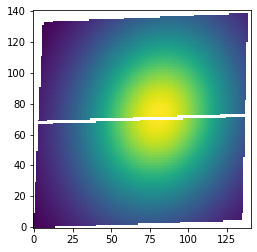

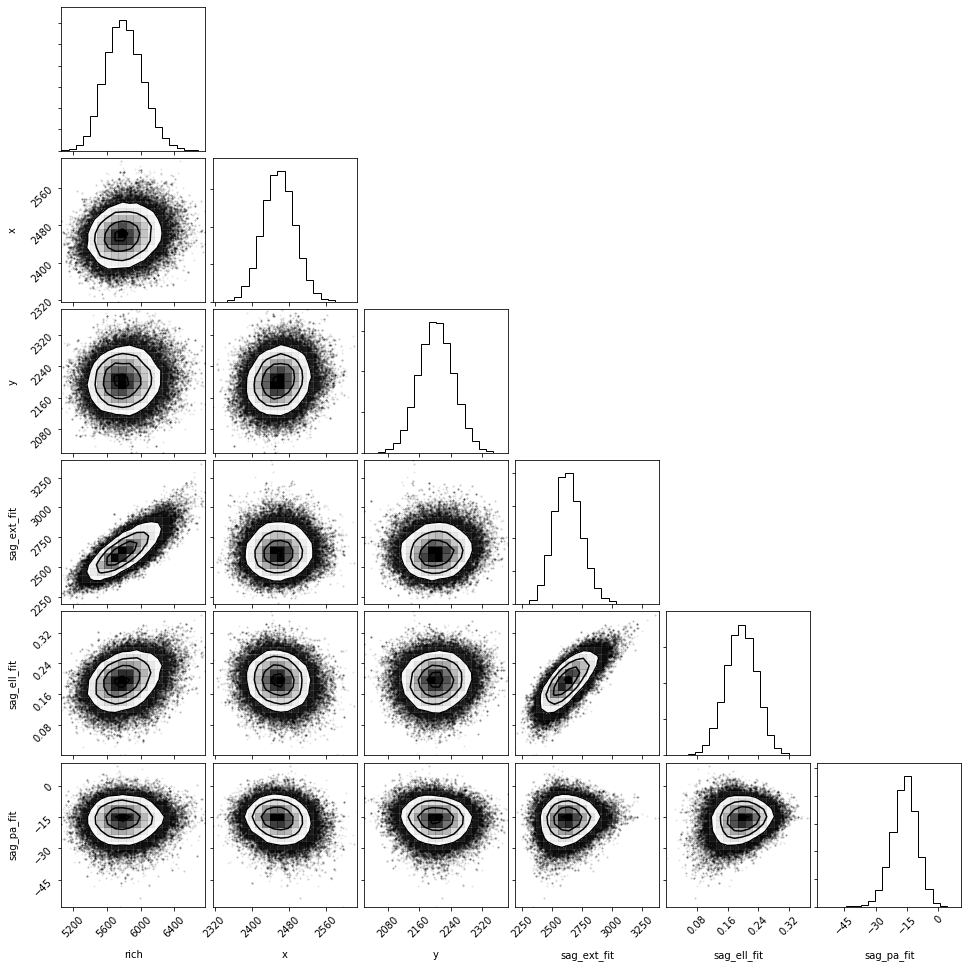

In [25]:
#FLAG FOR DISPLAYING PLOTS
do_plot=True
save_plot=True

#SET INITIAL GUESSES FOR PARAMETERS (ANY PARAMETERS NOT BEING FIT SHOULD BE REMOVED HERE)
THETA = [sag_nstar,sag_x0,sag_y0,sag_ext_pix,sag_ell,sag_pa]


#PLOT (MASKED, BINNED) OBSERVED SURFACE DENSITY
if do_plot:
    # Example of the masked counts and data
    # (transpose due to difference between imshow and histogram2d...)
    data_counts = data(xgood,ygood)
    data_counts_masked = np.copy(data_counts)
    data_counts_masked[np.where(MASK==0)] = np.nan
    plt.imshow(data_counts_masked.T,origin='lower')
    if save_plot:
        plt.savefig('data_counts_maskedSag0103jCut.png')


#VARIABLE TO HOLD FIT RESULTS
results = []
     
# Initialize and run the mcmc
print("Running mcmc...")
ndim, nwalkers = len(THETA), 100
nthreads,nsamples = 16, 3000
nburn = 1000
# pos = [THETA + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

pos = [THETA + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
     
sampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob,args=(xgood,ygood),
                                threads=nthreads)
sampler.run_mcmc(pos,nsamples)
     
samples = sampler.chain[:, nburn:, :].reshape((-1, ndim))

#MEDIAN VALUES AND +/-1 SIGMA FOR EACH FIT PARAMETER
rich,[rich_min,rich_max] = median_interval(samples[:,0])
x,[xmin,xmax] = median_interval(samples[:,1])
y,[ymin,ymax] = median_interval(samples[:,2])
sag_ext_fit,[sag_ext_min,sag_ext_max] = median_interval(samples[:,3])
sag_ell_fit,[sag_ell_min,sag_ell_max] = median_interval(samples[:,4])
sag_pa_fit,[sag_pa_min,sag_pa_max] = median_interval(samples[:,5])
# sag_bg_fit,[sag_bg_min,sag_bg_max] = median_interval(samples[:,6])

#POPULATE RESULTS ARRAY
res = [rich,rich_min,rich_max,x,xmin,xmax,y,ymin,ymax,sag_ext_fit,sag_ext_min,sag_ext_max,\
       sag_ell_fit,sag_ell_min,sag_ell_max,sag_pa_fit,sag_pa_min,sag_pa_max]
# results.append(res)

if do_plot:
    theta_sag = [rich,x,y,sag_ext_fit,sag_ell_fit,sag_pa_fit]
#     theta_cluster = [rich_cluster,x_cluster,y_cluster,cluster_ext_fit,cluster_ell_fit,cluster_pa_fit]
    model_counts_sag = model(theta_sag)
    model_counts = model_counts_sag #+ model_counts_cluster
    model_counts_masked = np.copy(model_counts)
    model_counts_masked[np.where(MASK==0)] = np.nan
#PLOT (MASKED, BINNED) MODEL SURFACE DENSITY
    plt.imshow(model_counts_masked.T,origin='lower')
    if save_plot:
        plt.savefig('model_counts_maskedSag0103jCut.png')

#CORNER PLOT    
    fig = corner.corner(samples, labels=["rich", "x", "y", "sag_ext_fit", "sag_ell_fit", "sag_pa_fit"])#"rich_cluster", "x_cluster", "y_cluster", "cluster_ext_fit", "cluster_ell_fit", "cluster_pa_fit"])
    if save_plot:
        fig.savefig("triangleSag0103jCut.png")

cPickle.dump(samples, open( "sag2mcmcSag0103jCut.p", "wb" ) )


In [26]:
res = [rich,rich_max-rich,rich-rich_min,x,xmax-x,x-xmin,y,ymax-y,y-ymin,
           sag_ext_fit,sag_ext_max-sag_ext_fit,sag_ext_fit-sag_ext_min,
           sag_ell_fit,sag_ell_max-sag_ell_fit,sag_ell_fit-sag_ell_min,
           sag_pa_fit,sag_pa_max-sag_pa_fit,sag_pa_fit-sag_pa_min]
print(res)

[5793.509368321039, 229.68673996023335, 210.07088321091032, 2457.6276117608973, 34.48718094328842, 34.00194068914743, 2203.0084129268043, 44.71619528767678, 43.86887477781465, 2626.3746288538086, 124.21384669623421, 111.97188237017053, 0.1949050138839219, 0.03975080509454798, 0.040303210931664696, -16.11592815899127, 5.617530803673123, 6.103122534467541]


In [31]:
samples = cPickle.load( open( "sag2mcmcPL1202.p", "rb" ) )
#MEDIAN VALUES AND +/-1 SIGMA FOR EACH FIT PARAMETER
rich,[rich_min,rich_max] = median_interval(samples[:,0])
x,[xmin,xmax] = median_interval(samples[:,1])
y,[ymin,ymax] = median_interval(samples[:,2])
sag2_ext_fit,[sag2_ext_min,sag2_ext_max] = median_interval(samples[:,3])
sag2_ell_fit,[sag2_ell_min,sag2_ell_max] = median_interval(samples[:,4])
sag2_pa_fit,[sag2_pa_min,sag2_pa_max] = median_interval(samples[:,5])

res = [rich,rich_min,rich_max,x,xmin,xmax,y,ymin,ymax,sag2_ext_fit,sag2_ext_min,sag2_ext_max,\
       sag2_ell_fit,sag2_ell_min,sag2_ell_max,sag2_pa_fit,sag2_pa_min,sag2_pa_max]#,rich_cluster,rich_cluster_min,rich_cluster_max,x_cluster,x_cluster_min,x_cluster_max,y_cluster,y_cluster_min,y_cluster_max,cluster_ext_fit,cluster_ext_min,cluster_ext_max,cluster_ell_fit,cluster_ell_min,cluster_ell_max,cluster_pa_fit,cluster_pa_min,cluster_pa_max]
# results.append(res)

In [32]:
print(res)

[9934.694959531427, 9835.035995336157, 9983.288981158206, 2428.731514586525, 2398.813588510706, 2459.3503041206795, 2294.560515331195, 2261.869554800667, 2327.958327422131, 2523.159622925976, 2460.003082650415, 2587.8577444210787, 0.08713038929471563, 0.04613869369738329, 0.12465374426152073, -7.1353868765032615, -18.856772448655853, 3.776554504157472]


In [51]:
xorig = cat['x_f606w']
yorig = cat['y_f606w']
m606 = cat['magr_f606w']
dm606 = cat['err_f606w']
m814 = cat['magr_f814w']
dm814 = cat['err_f814w']

In [39]:
# BEST-FIT sag2 I PARAMETERS (FROM MCMC_STRUCTURAL_FIT)
# richness = rich
# x0 = x
# y0 = y
# gal_ext_pix = sag2_ext_fit

# gal_ell = sag2_ell_fit
# gal_pa = sag2_pa_fit

richness = 6071
x0 = 2527
y0 = 2235
gal_ext_pix = 2677

gal_ell = 0.14
gal_pa = -8

In [40]:
xbin0 = np.ones((179,1))  # (fltarr(267)+1)
xbin1 = np.ones((1,179))  
xbin1[0] = np.arange(0,179,1)
xbin2 = xbin1 * 30 + 15  # (findgen(267)*30. + 15)
xbin = np.matmul(xbin0,xbin2)
ybin = xbin.T

# creating x and y arrays to represent the bins across the image

In [41]:
costh = np.cos(-1 * np.deg2rad(gal_pa))
sinth = np.sin(-1 * np.deg2rad(gal_pa))

dx = xbin - x0
dy = ybin - y0

In [42]:
r1 = (dx * costh - dy * sinth) / (1 - gal_ell)
r2 = (dx * sinth + dy * costh)

radius = np.sqrt(r1**2 + r2**2)
# calculating distances to different bins in the annuli based on the PA

In [43]:
r_h = gal_ext_pix
norm = r_h**2 / (np.pi * (1-gal_ell))
# half light radius squared / (pi * 1-ell)
pdf = norm/((radius**2 + r_h**2)**2)

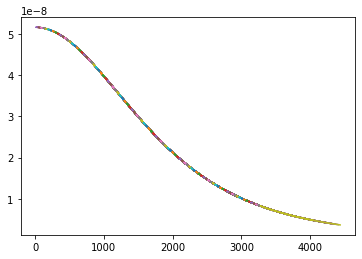

In [44]:
fig, ax = plt.subplots()

ax.plot(radius,pdf)

plt.show()

In [53]:
xdel = 30.
ydel = 30.
pixarea = xdel*ydel  # pixel area in each bin

In [54]:
model_counts_gal = richness*pdf*pixarea  # a 267x267 array

In [55]:
# Observed surface density map
binned_surface_density_30 = np.zeros((179,179))
for ii in range(179):
    for jj in range(179):
        idxgood = np.logical_and(np.logical_and(xgood >= (30 * ii),xgood <= (30 * (ii + 1))),
                     np.logical_and(ygood >= (30 * jj),ygood <= (30 * (jj + 1))))

        tmp = np.where(idxgood)[0]
#         # flipping ii and jj because in IDL, it's col, row.
        binned_surface_density_30[jj,ii] = len(tmp)

In [57]:
# Define annuli
radius1=radius.flatten()
r1 = np.where(radius1 < (0.1 * r_h))
r2 = np.where((radius1 < (0.2 * r_h)) & (radius1 >= (0.1 * r_h)))
r3 = np.where((radius1 < (0.3 * r_h)) & (radius1 >= (0.2 * r_h)))
r4 = np.where((radius1 < (0.4 * r_h)) & (radius1 >= (0.3 * r_h)))
r5 = np.where((radius1 < (0.5 * r_h)) & (radius1 >= (0.4 * r_h)))
r6 = np.where((radius1 < (0.6 * r_h)) & (radius1 >= (0.5 * r_h)))
r7 = np.where((radius1 < (0.7 * r_h)) & (radius1 >= (0.6 * r_h)))
r8 = np.where((radius1 < (0.8 * r_h)) & (radius1 >= (0.7 * r_h)))
r9 = np.where((radius1 < (0.9 * r_h)) & (radius1 >= (0.8 * r_h)))
r10 = np.where((radius1 < r_h) & (radius1 >= (0.9 * r_h)))

In [58]:
# To get the actual indices
r1v = r1[0]
r2v = r2[0]
r3v = r3[0]
r4v = r4[0]
r5v = r5[0]
r6v = r6[0]
r7v = r7[0]
r8v = r8[0]
r9v = r9[0]
r10v = r10[0]

In [131]:
# r_annuli = (findgen(10) + 0.05)*r_h
# area_annuli = !pi*( (r_annuli + 0.05)^2 - (r_annuli - 0.05)^2)

# r_h is in pixels
# area is pixel squared
# pixel squared to arcmin squared... how many pixels in an arcmin?
# 20 pixels per arcsec, 1200 pixels=1 arcmin
# 1 arcmin squared : 1200^2 pixels

# arr = np.arange(0,10,1)
arr = np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
r_annuli = (arr + 0.05) * r_h

# .05r_h, .15r_h
area_annuli = np.pi * ( (r_annuli + (0.05*r_h))**2 - (r_annuli - (0.05*r_h))**2) * (1-gal_ell)

In [132]:
r_annuli

array([ 133.85,  401.55,  669.25,  936.95, 1204.65, 1472.35, 1740.05,
       2007.75, 2275.45, 2543.15])

In [133]:
area_annuli

array([ 193617.70424062,  580853.11272187,  968088.52120312,
       1355323.92968437, 1742559.33816562, 2129794.74664687,
       2517030.15512812, 2904265.56360936, 3291500.97209061,
       3678736.38057186])

In [134]:
pix_per_arcsec=20
area_arcmin = area_annuli/(pix_per_arcsec*60)**2

In [135]:
area_arcmin

array([0.13445674, 0.40337022, 0.6722837 , 0.94119717, 1.21011065,
       1.47902413, 1.74793761, 2.01685109, 2.28576456, 2.55467804])

In [107]:
# # areas of annuli in arcmin**2

# a1 = (np.pi*(np.pi*(r_h*0.1 + 0.05)**2*(1-gal_ell) - np.pi*(r_h*0.1 - 0.05)**2 \ 
#           *(1-gal_ell))/(pix_per_arcsec*60)**2
# a2 = (np.pi*(r_h*0.2)**2*(1-gal_ell) - np.pi*(r_h*0.1)**2 \ 
#           *(1-gal_ell))/(pix_per_arcsec*60)**2
# a3 = (np.pi*(r_h*0.3)**2*(1-gal_ell) - np.pi*(r_h*0.2)**2 \ 
#           *(1-gal_ell))/(pix_per_arcsec*60)**2
# a4 = (np.pi*(r_h*0.4)**2*(1-gal_ell) - np.pi*(r_h*0.3)**2 \ 
#           *(1-gal_ell))/(pix_per_arcsec*60)**2
# a5 = (np.pi*(r_h*0.5)**2*(1-gal_ell) - np.pi*(r_h*0.4)**2 \ 
#           *(1-gal_ell))/(pix_per_arcsec*60)**2
# a6 = (np.pi*(r_h*0.6)**2*(1-gal_ell) - np.pi*(r_h*0.5)**2 \ 
#           *(1-gal_ell))/(pix_per_arcsec*60)**2
# a7 = (np.pi*(r_h*0.7)**2*(1-gal_ell) - np.pi*(r_h*0.6)**2 \ 
#           *(1-gal_ell))/(pix_per_arcsec*60)**2
# a8 = (np.pi*(r_h*0.8)**2*(1-gal_ell) - np.pi*(r_h*0.7)**2 \ 
#           *(1-gal_ell))/(pix_per_arcsec*60)**2
# a9 = (np.pi*(r_h*0.9)**2*(1-gal_ell) - np.pi*(r_h*0.8)**2 \ 
#           *(1-gal_ell))/(pix_per_arcsec*60)**2
# a10 = (np.pi*(r_h*1.0)**2*(1-gal_ell) - np.pi*(r_h*0.9)**2 \ 
#            *(1-gal_ell))/(pix_per_arcsec*60)**2

In [129]:
# a1 = (np.pi*(r_h*0.1)**2*(1-gal_ell))/(pix_per_arcsec*60)**2

In [130]:
# a1

0.13445673905598915

In [136]:
aa = area_arcmin

In [137]:
dist_x = np.array([r_h*0.1,r_h*0.2,r_h*0.3,r_h*0.4,r_h*0.5,r_h*0.6,r_h*0.7,r_h*0.8,r_h*0.9,r_h])/1200

In [138]:
binned_surface_density_30f = binned_surface_density_30.flatten()
model_counts_galf = model_counts_gal.flatten()
# model_counts_expf = model_counts_exp.flatten()
data_1d = [binned_surface_density_30f[r1v].sum()/aa[0],
           binned_surface_density_30f[r2v].sum()/aa[1],
           binned_surface_density_30f[r3v].sum()/aa[2],
           binned_surface_density_30f[r4v].sum()/aa[3],
           binned_surface_density_30f[r5v].sum()/aa[4],
           binned_surface_density_30f[r6v].sum()/aa[5],
           binned_surface_density_30f[r7v].sum()/aa[6],
           binned_surface_density_30f[r8v].sum()/aa[7],
           binned_surface_density_30f[r9v].sum()/aa[8],
           binned_surface_density_30f[r10v].sum()/aa[9]]

model_1d = [model_counts_galf[r1v].sum()/aa[0],
            model_counts_galf[r2v].sum()/aa[1],
            model_counts_galf[r3v].sum()/aa[2],
            model_counts_galf[r4v].sum()/aa[3],
            model_counts_galf[r5v].sum()/aa[4],
            model_counts_galf[r6v].sum()/aa[5],
            model_counts_galf[r7v].sum()/aa[6],
            model_counts_galf[r8v].sum()/aa[7],
            model_counts_galf[r9v].sum()/aa[8],
            model_counts_galf[r10v].sum()/aa[9]]

# model_1de = [model_counts_expf[r1ve].sum()/a1,
#             model_counts_expf[r2ve].sum()/a2,
#             model_counts_expf[r3ve].sum()/a3,
#             model_counts_expf[r4ve].sum()/a4,
#             model_counts_expf[r5ve].sum()/a5,
#             model_counts_expf[r6ve].sum()/a6,
#             model_counts_expf[r7ve].sum()/a7,
#             model_counts_expf[r8ve].sum()/a8,
#             model_counts_expf[r9ve].sum()/a9,


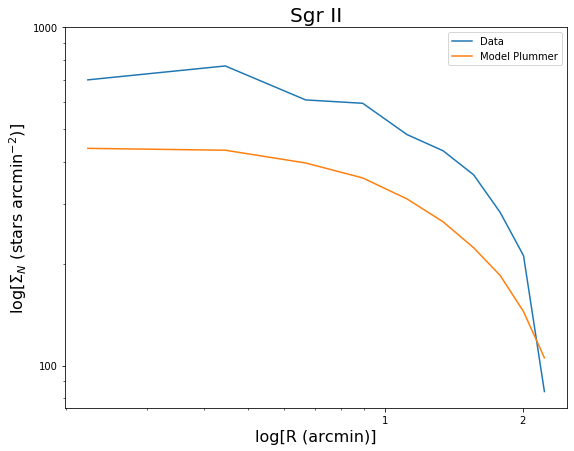

In [144]:
fig, ax = plt.subplots(figsize=(9,7))

ax.plot(dist_x,data_1d,label='Data')
ax.plot(dist_x,model_1d,label='Model Plummer')
# ax.plot(dist_x,model_1de,label='Model Exp')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylabel(r'log[$\Sigma_N$ (stars arcmin$^{-2}$)]',fontsize=16)
ax.set_xlabel(r'log[R (arcmin)]',fontsize=16)
ax.set_title('Sgr II',fontsize=20)

ax.set_xticks([1, 2])
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

ax.set_yticks([1e+2, 1e+3])
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

ax.legend()
plt.savefig('figures/sgr2_1102.png')
plt.show()

In [50]:
print(res)

[9935.176723451139, 9839.504598511438, 9983.22804699672, 2322.143305847342, 2289.769370661656, 2354.6818557594374, 2279.6503859597997, 2249.2841726501388, 2310.167143111831, 2500.238175381608, 2439.6473347118754, 2564.0629224941736, 0.06962035632725823, 0.027722117745307542, 0.10912473478153377, 62.78531086516453, 45.38262701561668, 68.13984354080236]


In [43]:
4801-5420

-619

In [ ]:
#dummy

In [ ]:
for i in range(0,nwalkers-1):
    plt.plot(sampler.chain[i,:,1],linewidth=1,color='black')

In [ ]:
#EXAMINE RESIDUALS NEAR THE CENTER OF THE GALAXY
plt.imshow(model_counts.T*(1-gap_mask.T)-data_counts.T*(1-gap_mask.T),origin="lower")
plt.colorbar()
plt.xlim(70,170)
plt.ylim(70,170)
plt.clim(-2.5,2.5)